### Load in DESeq2 Results

As mentioned, I ran DESeq2 in a separate notebook. I ran two tests, one that just compares every stim to the control for every non-zero time point (labeled by the hour in the cell below), and another that tries to model stimulation-specific changes over time (labeled as TC below). I'll read in all, but since I'm not *exactly* sure how to interpret the latter, I'm really only going to focus on the former in this notebook.

In [2]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import matplotlib as mpl
import seaborn as sns
import pickle as pkl
import itertools as it
from functools import reduce
import scanpy as sc
import scipy

And then some from the [goatools](https://github.com/tanghaibao/goatools) Gene Ontology package for Python. Most of the code here modeled after the [notebooks](https://github.com/tanghaibao/goatools#ipython-notebooks) found on the Github.

In [3]:
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.test_data.genes_NCBI_9606_ProteinCoding import GENEID2NT as GeneID2nt_hum
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

In [4]:
prefix = '/data/codec/production.run/mrna/'

In [5]:
conds_1 = ['A', 'B', 'G', 'P', 'R']
cts_1 = ['B_Memory', 'B_Naive', 'CD4_T_Memory', 'CD4_T_Naive', 'CD8_T_Memory_MAIT_GD', 'CD8_T_Naive', 'HSC', 'NK', 'pDC','Mono_cDC_All']

Read in the results.

In [6]:
de = dict() # differential expression dictionary
for cond in conds_1:
    de[cond] = dict()
    
combos = it.product(conds_1, cts_1)
for combo in combos:
    de[combo[0]][combo[1]] = pd.read_csv(prefix + 'deseq2.res/' + combo[0] + '.' + combo[1] + '.csv', index_col=0).dropna()  

In [7]:
conds_2 = ['A', 'B', 'G', 'R']
cts_2 = ['Mono_C', 'Mono_NC', 'cDC']

In [8]:
combos = it.product(conds_2, cts_2)
for combo in combos:
    de[combo[0]][combo[1]] = pd.read_csv(prefix + 'deseq2.res/' + combo[0] + '.' + combo[1] + '.csv', index_col=0).dropna()  

### Plot The Positive Half of the Volcano Plot for Any Sample

Just focusing on those genes that were increased in expression relatively to control.

In [9]:
stim = 'R'
ct = 'B_Memory'

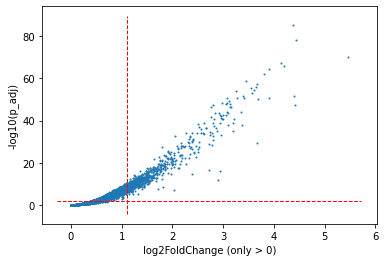

In [10]:
df = de[cond][ct]
df = df[df['log2FoldChange'] > 0]
fc_thresh = np.percentile(df['log2FoldChange'],90)

plt.scatter(df['log2FoldChange'].values, 
            -np.log10(df['padj']).values,
           s=1);

xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()


#########################################################################################################
# Through testing with multiple samples, I think a good metric for determining differentially expressed genes involves a strict p_adj value cutoff (0.05) 
# and a dynamic log fold change threshold that changes depending on the sample. I'm using the log2foldchange value at the 90th %ile of positive values
#########################################################################################################

# drawing cutoffs here
plt.plot(xlim, [-np.log10(0.01)]*2, linewidth=1, c='r', linestyle='--');
plt.plot([fc_thresh]*2, ylim, linewidth=1, c='r', linestyle='--');

plt.xlabel('log2FoldChange (only > 0)')
plt.ylabel('-log10(p_adj)');

### Get Pseudobulks

In [11]:
pseudobulk = pd.read_pickle(prefix + 'pkls/aggr/pseudobulk.cts.pkl')
# this object is a pseudobulk (sum) over all the cells in a particular condition in a particular condition
# summing makes sense over all the cells, but to get a measure of centrality for each condition-cell type, I will take the *mean* of individuals

In [12]:
ct_cond_combos = list(it.product(cts_1, conds_1)) + list(it.product(cts_2, conds_2))

In [13]:
pseudobulk_conds_cts_list = list()
for ct, cond in tqdm(ct_cond_combos):
    mean_ind = pseudobulk[(pseudobulk['CT'] == ct) & (pseudobulk['COND'] == cond)].iloc[:,3:].mean(0).values.tolist()
    pseudobulk_conds_cts_list.append([ct, cond] +  mean_ind)

In [14]:
pseudobulk_conds_cts = pd.DataFrame(pseudobulk_conds_cts_list, columns = ['CT', 'COND'] + pseudobulk.columns.tolist()[3:])

In [15]:
# Just confirm that no genes have counts of zero.
(pseudobulk_conds_cts.iloc[:,2:].sum(0) == 0).sum() == 0

True

## DE Genes: 2-sided, Static Cutoffs

Using a static cutoff for LFC and strict p_adj < 0.01, I will now extract out differentially expressed genes. At Hyun's suggestion, using only the top _n_ significant genes from each comparison, since some conditions like PMAI and R848 have 1000s, while TNF-alpha conditions have in the 10s or 100. Using the top 200 from each condition will not bias the heatmap towards the most stimulating conditions.

In [16]:
de_genes = dict() # make a dictionary

num_top_genes_to_keep = 200
for ct, cond in ct_cond_combos: 
    try:
        de_genes[ct]
    except KeyError:
        de_genes[ct] = dict()

    df = de[cond][ct] # get the DE results
    df = df[(df['log2FoldChange'] > 2) | (df['log2FoldChange'] < -2)]
    
    # extract out genes, add them to the dictionary as a list
    df_significant = df[(df['padj'] < 0.05)]
    de_genes[ct][cond] = df.sort_values('padj').index[:num_top_genes_to_keep]

all_de_genes = list()
lengths = list()
for ct, cond in ct_cond_combos:
    de_genes_list = de_genes[ct][cond]
    length = len(de_genes_list)
    lengths.append(length)
#     print((ct, cond, length))
    all_de_genes.append(de_genes[ct][cond])

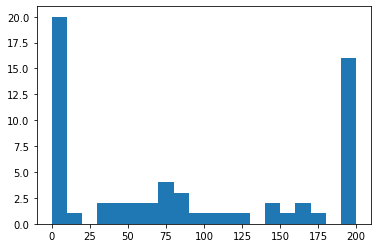

In [17]:
plt.hist(lengths, bins=20);

In [18]:
all_de_genes = np.unique([i for j in all_de_genes for i in j])

Turn the counts matrix into an adata object for easy processing like normalize, log1p, and scaling.

In [19]:
counts_for_heatmap = pseudobulk_conds_cts.iloc[:,2:]
obs = pd.DataFrame(index=pseudobulk_conds_cts['CT'] + '-' + pseudobulk_conds_cts['COND'])
var = pd.DataFrame(index=pseudobulk_conds_cts.iloc[:,2:].columns)

In [20]:
adata = sc.AnnData(X=counts_for_heatmap.values, obs=obs, var=var)
adata.var_names_make_unique()

In [21]:
adata

AnnData object with n_obs × n_vars = 62 × 20303

In [22]:
sc.pp.normalize_total(adata, target_sum=1e6)

In [23]:
adata.raw = adata.copy()

In [24]:
sc.pp.log1p(adata)

In [25]:
sc.pp.scale(adata)

Now back to a df because it's simpler.

In [26]:
df_de = pd.DataFrame(adata[:,all_de_genes].X, index=obs.index, columns=all_de_genes)

In [27]:
df_de.shape

(62, 1583)

## Plotting

### Clustering by Tree Cut

#### Naive Coloring

Better to separately make the linkage matrix, becuase I'm going to want to cluster the genes based on it.

In [27]:
Z = scipy.cluster.hierarchy.linkage(df_de.T, method='average', optimal_ordering=True)

Gotta love scanpy's colors:

In [28]:
num_modules = 100
color_dict = dict(zip(range(num_modules),sc.pl.palettes.default_102))

/home/ssm-user/anaconda3/envs/codec/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


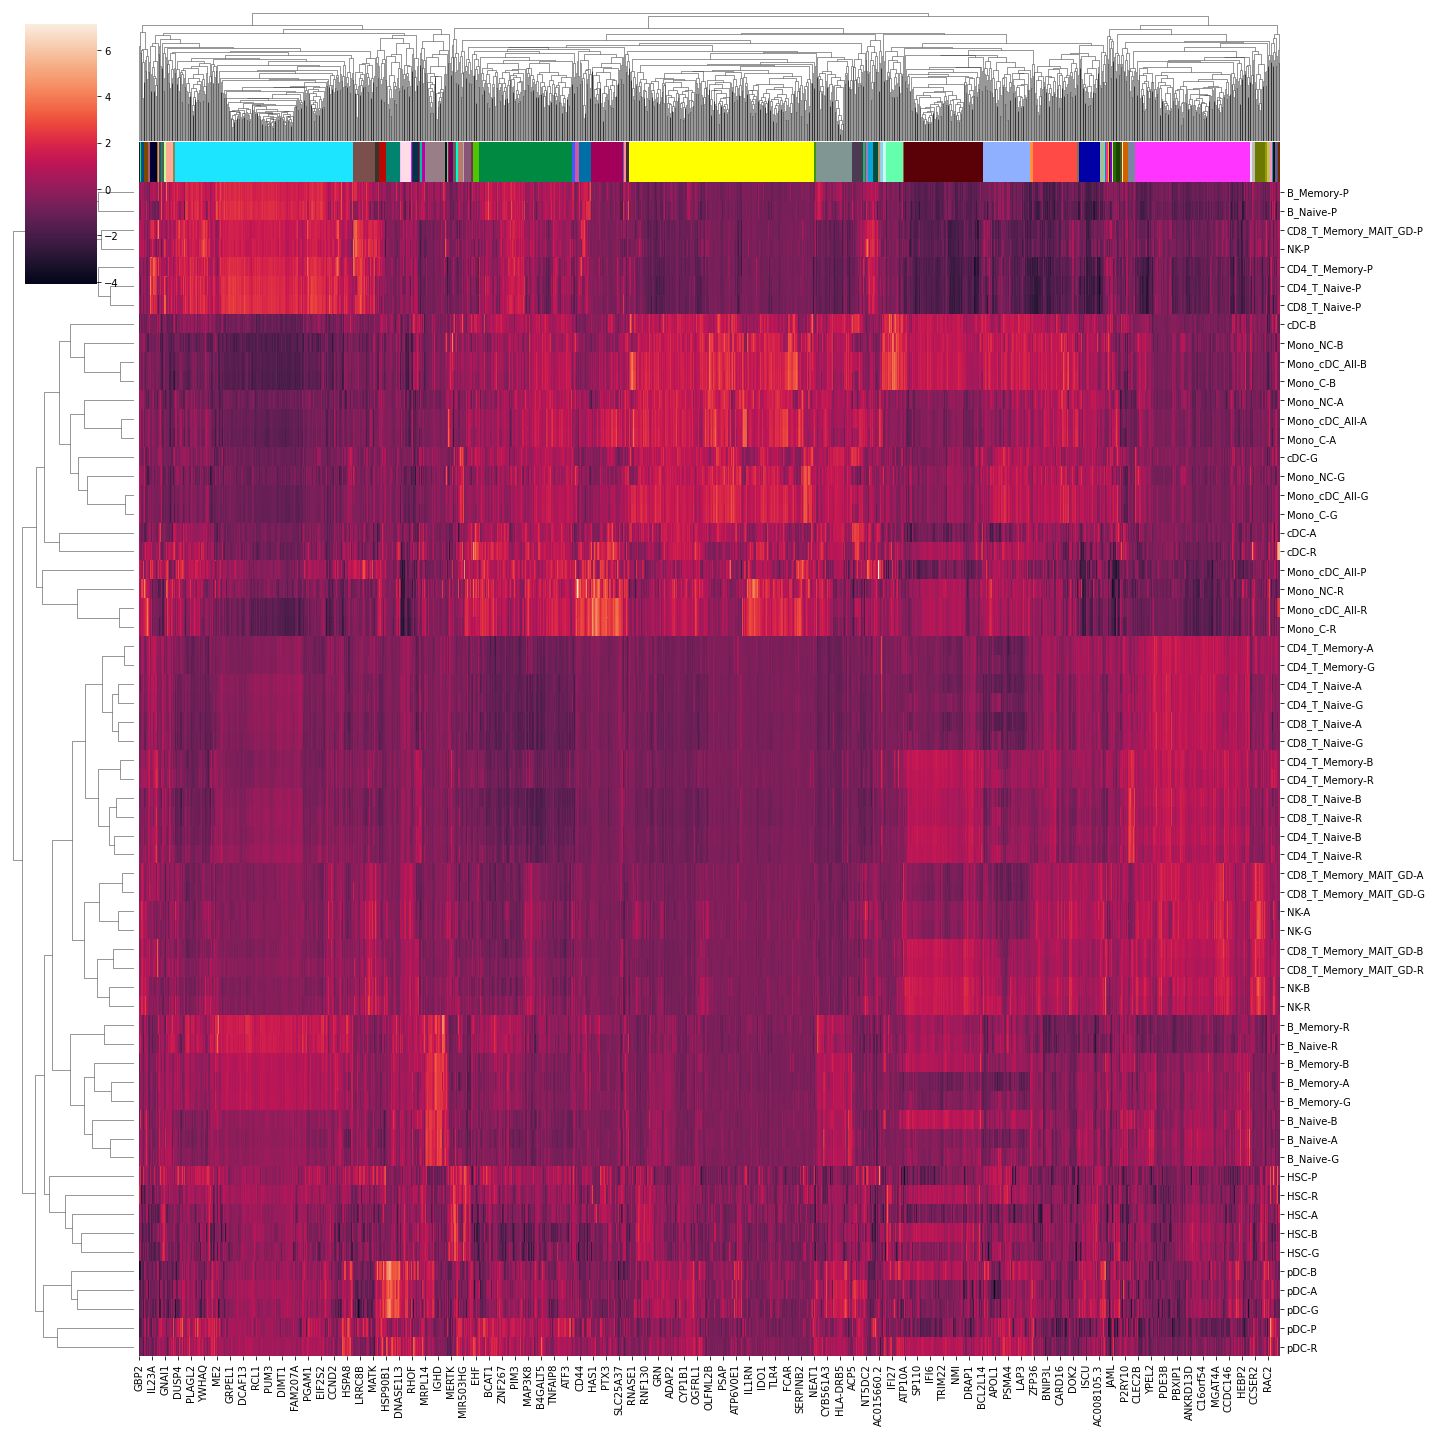

In [29]:
modules = scipy.cluster.hierarchy.cut_tree(Z, num_modules).flatten()
sns.clustermap(df_de, figsize=(20,20), 
               row_cluster=True,
               col_linkage=Z, 
               col_colors=list(map(lambda x: color_dict[x], modules)),
               dendrogram_ratio=0.1,
              );
# plt.tight_layout()

#### Get Labels and Color according to Size

In [30]:
# credit to user Has QUIT--Anony-Mousse from https://stackoverflow.com/questions/12572436/calculate-ordering-of-dendrogram-leaves
n = len(Z) + 1
cache = dict()
for k in range(len(Z)):
    c1, c2 = int(Z[k][0]), int(Z[k][1])
    c1 = [c1] if c1 < n else cache.pop(c1)
    c2 = [c2] if c2 < n else cache.pop(c2)
    cache[n+k] = c1 + c2
ordering = cache[2*len(Z)]

In [31]:
# cmap = mpl.cm.get_cmap('prism')

In [32]:
modules = scipy.cluster.hierarchy.cut_tree(Z, num_modules).flatten()[ordering]

In [33]:
module_vals, module_counts = np.unique(modules, return_counts=True)

In [34]:
modules_size_ordered = pd.DataFrame(data=zip(module_vals, module_counts),
                                    columns=['v','c']).sort_values('c', ascending=False)['v'].values

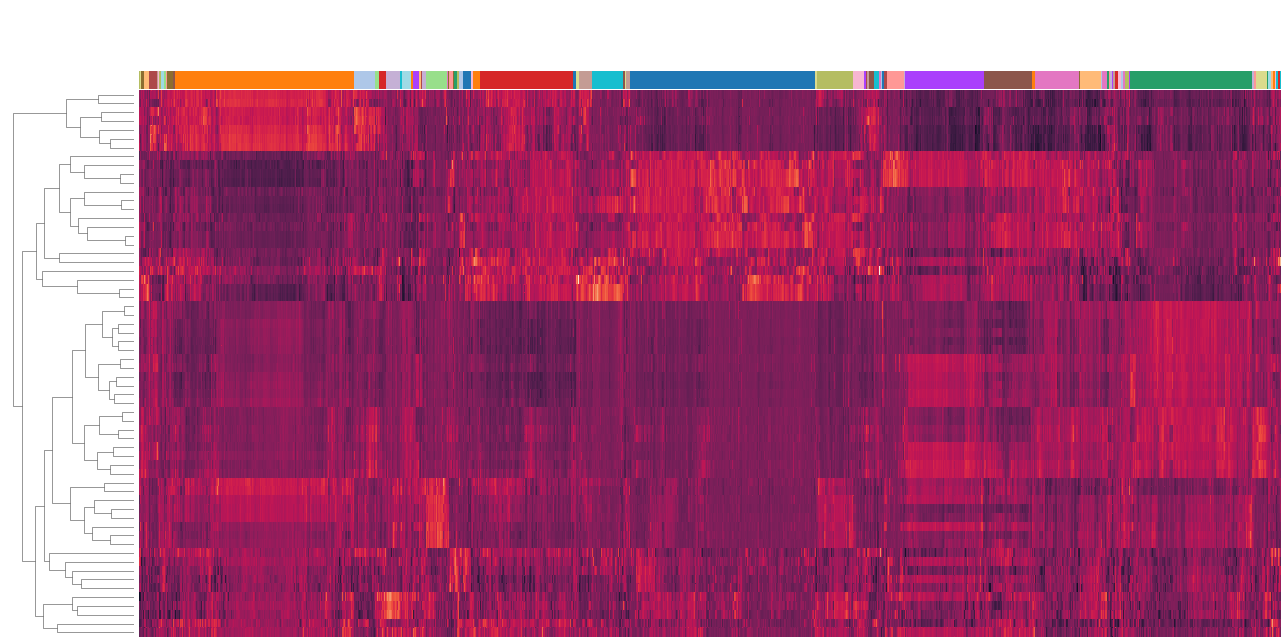

In [35]:
color_dict = dict(zip(modules_size_ordered,sc.pl.palettes.default_20*int(np.ceil(num_modules/len(sc.pl.palettes.default_20)))))
genes = df_de.columns.values[ordering]
cg = sns.clustermap(df_de[genes], figsize=(20,10), 
                    row_cluster=True,
                    col_cluster=False,
                    col_linkage=Z, 
                    col_colors=list(map(lambda x: color_dict[x], modules)),
                    dendrogram_ratio=0.1,
                    cbar_pos=None
                   );
cg.ax_heatmap.set_yticklabels([])
cg.ax_heatmap.set_yticks([])
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.set_xticks([]);

#### Module Identification

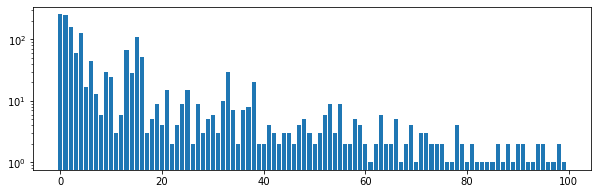

In [36]:
plt.figure(figsize=(10,3))
plt.bar(module_vals, module_counts);#, s=5);
plt.yscale('log');

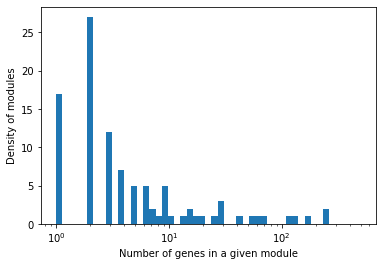

In [37]:
plt.hist(module_counts, bins=np.logspace(np.log10(1), np.log10(500), 50));
plt.xscale('log')
plt.xlabel('Number of genes in a given module')
plt.ylabel('Density of modules');

Only want to keep the main modules:

In [38]:
main_modules = np.arange(num_modules)[module_counts > 5]
main_modules_genes = dict()
for module in main_modules:
    main_modules_genes[module] = genes[modules == module]

In [39]:
len(main_modules_genes)

32

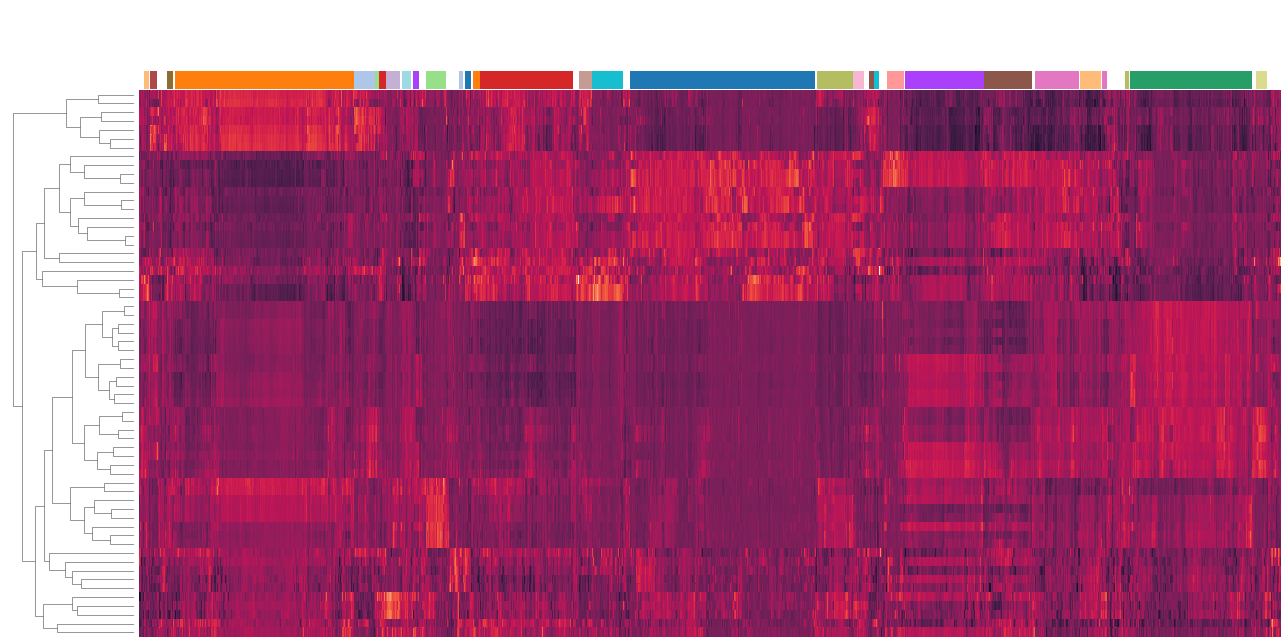

In [40]:
colorful_colors = sc.pl.palettes.default_20*int(np.ceil(num_modules/len(sc.pl.palettes.default_20)))
colors = colorful_colors[:len(main_modules_genes)] + ['#FFFFFF']*(num_modules-len(main_modules_genes))
color_dict = dict(zip(modules_size_ordered, colors))

genes = df_de.columns.values[ordering]
cg = sns.clustermap(df_de[genes], figsize=(20,10), 
                    row_cluster=True,
                    col_cluster=False,
                    col_linkage=Z, 
                    col_colors=list(map(lambda x: color_dict[x], modules)),
                    dendrogram_ratio=0.1,
                    cbar_pos=None
                   );
cg.ax_heatmap.set_yticklabels([])
cg.ax_heatmap.set_yticks([])
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.set_xticks([]);

Visualize the colors for the modules.

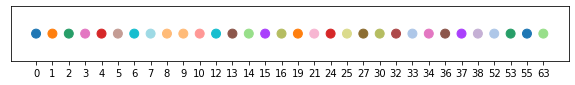

In [41]:
plt.figure(figsize=(10,1))
plt.scatter(list(main_modules.astype(str)), [1]*len(main_modules), c=list(map(mpl.colors.hex2color, map(lambda x: color_dict[x], main_modules))), s=80);
plt.yticks([]);

### Clustering by KMeans

In [28]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

Code for finding optimal k taken from [here](https://pythonprogramminglanguage.com/kmeans-elbow-method/).

In [29]:
distortions = list()
K = np.concatenate(([1],np.arange(5,105,5)))
for k in tqdm(K):
    kmeanModel = KMeans(n_clusters=k).fit(df_de.T)
    kmeanModel.fit(df_de.T)
    distortions.append(sum(np.min(cdist(df_de.T, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_de.T.shape[0])

In [30]:
rise = [distortions[i] - distortions[i - 1] for i in range(1, len(K))]
run = [K[i] - K[i - 1] for i in range(1, len(K))]
slopes = np.array([-i/j for i, j in zip(rise, run)])

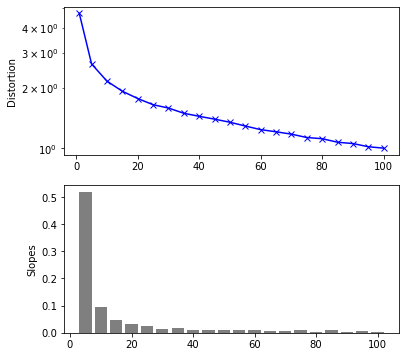

In [31]:
# Plot the elbow
fig, ax = plt.subplots(2, 1, figsize=(6,6))
ax[0].plot(K, distortions - min(distortions) + 1, 'bx-')
ax[0].set_ylabel('Distortion')
ax[0].set_yscale('log')
ax[1].bar(K[1:], slopes, width=4, color='k', alpha=0.5)
ax[1].set_ylabel('Slopes');

In [32]:
n_clusts = 30
kmeans = KMeans(n_clusters=n_clusts).fit(df_de.T)

In [43]:
prefix

'/data/codec/production.run/mrna/'

In [44]:
# with open(prefix + 'go.analysis/kmeans.modules/kmeans.n30.out.pkl', 'wb') as file:
#     pkl.dump(kmeans, file)

In [45]:
with open(prefix + 'go.analysis/kmeans.modules/kmeans.n30.out.pkl', 'rb') as file:
    kmeans = pkl.load(file)

Gotta love scanpy's colors:

In [46]:
color_dict = dict(zip(range(n_clusts),sc.pl.palettes.default_20*2))

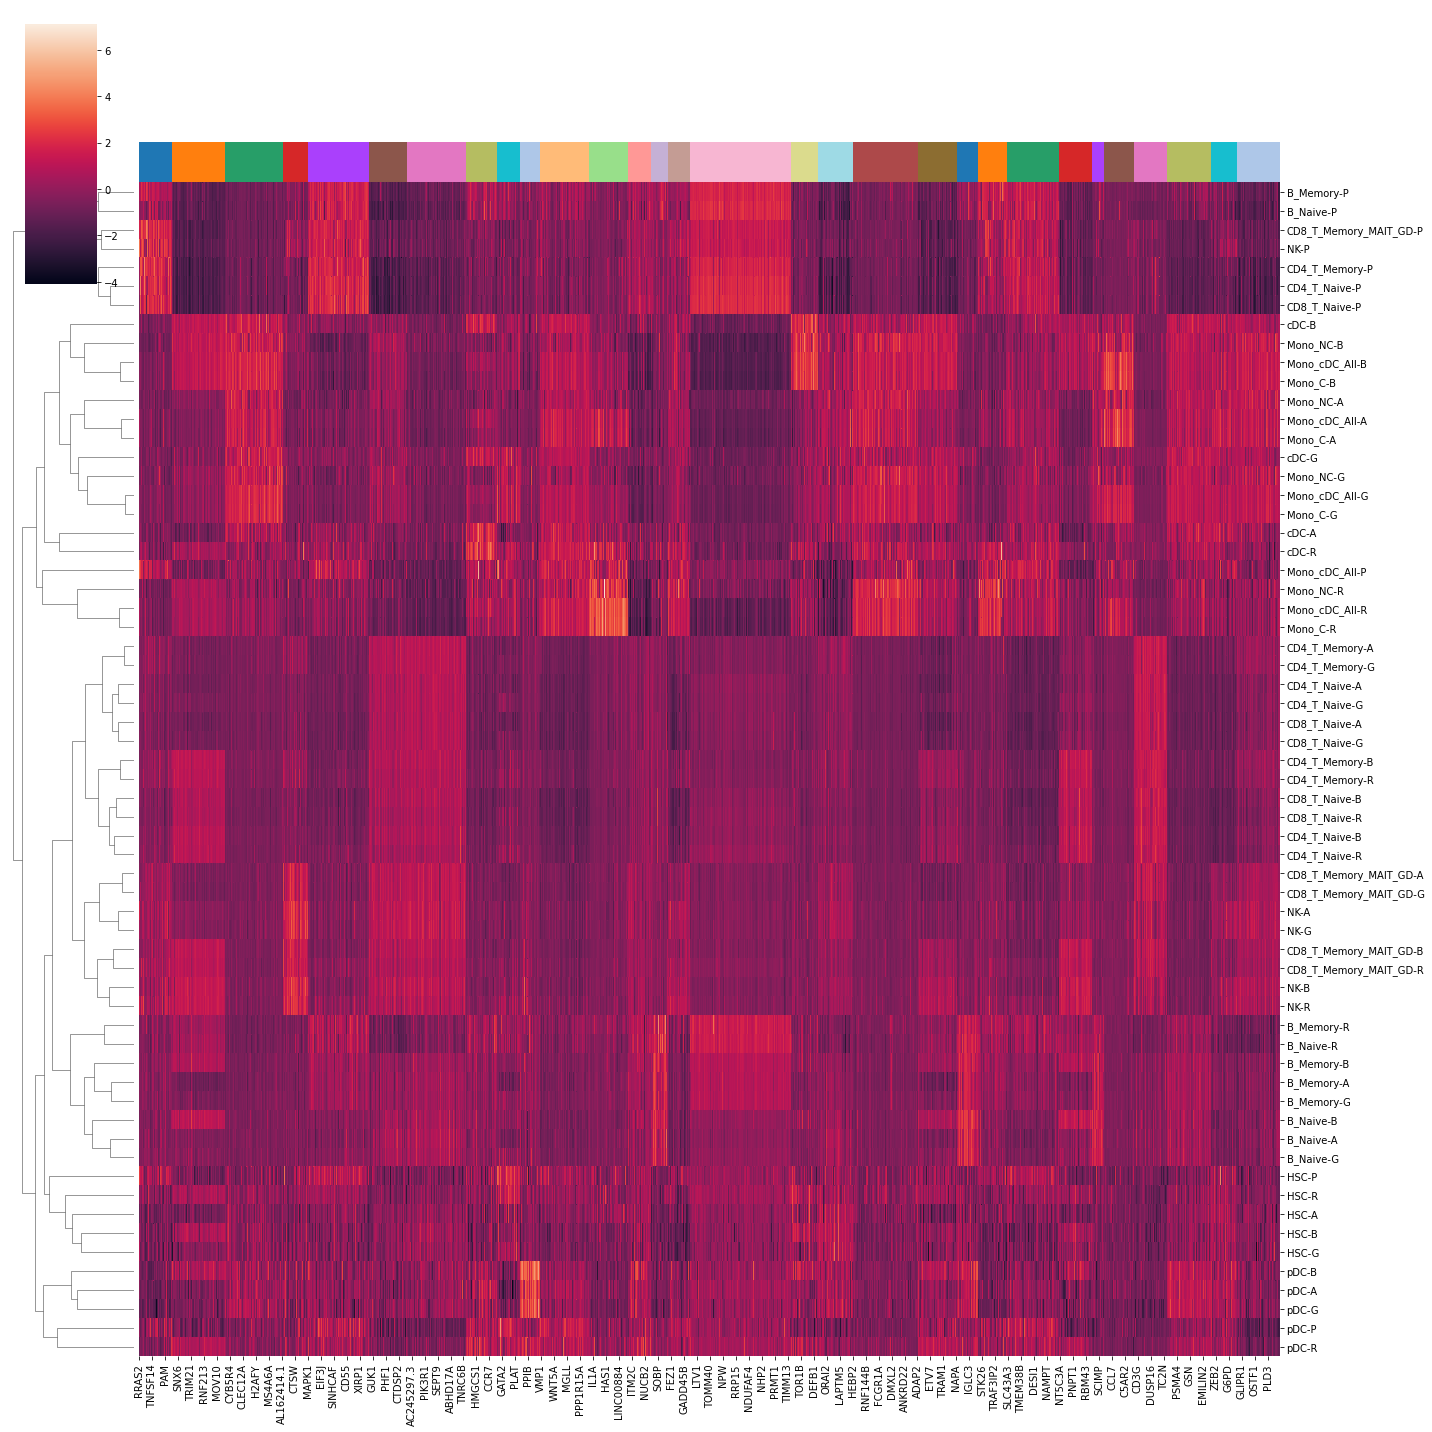

In [47]:
cg = sns.clustermap(df_de.iloc[:,np.argsort(kmeans.labels_)], figsize=(20,20), 
                    row_cluster=True,
                    col_cluster=False,
                    col_colors=list(map(lambda x: color_dict[x], np.sort(kmeans.labels_))),
                    dendrogram_ratio=0.1,
                   );
# plt.tight_layout()

In [48]:
ordered_cts = [i.split('-')[0] for i in df_de.index]
ordered_conds = [i.split('-')[1] for i in df_de.index]

In [49]:
import pickle as pkl

In [50]:
with open(prefix + '../cond.colors.pkl', 'rb') as file:
    cond_colors = pkl.load(file)['hex']

In [51]:
with open(prefix + '../ct.colors.pkl', 'rb') as file:
    ct_colors = pkl.load(file)['hex']

In [52]:
np.setdiff1d(np.unique(ordered_cts), np.array(list(ct_colors.keys())))

array(['Mono_cDC_All'], dtype='<U20')

In [53]:
ct_colors['Mono_cDC_All'] = '#808080' # make it gray

At Jimmie's suggestion, I'm going to make an additional column color to compare the genes that were found differentially expressed in the bulk.

In [54]:
with open(prefix + '../../bulk.jan20/kmeans.modules/kmeans.n30.main.modules.genes.pkl', 'rb') as file:
    bulk_main_modules_genes = pkl.load(file)
    bulk_main_modules_genes = np.unique(np.concatenate([i for i in bulk_main_modules_genes.values()]))

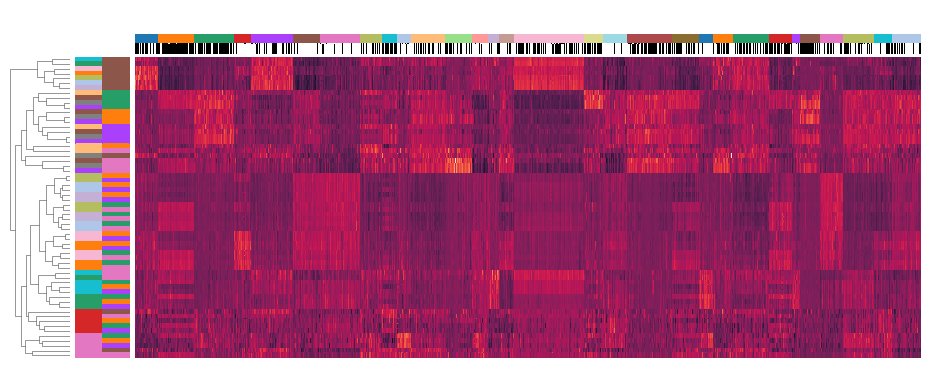

In [57]:
bulk_color = {True: '#000000',
              False: '#FFFFFF'
             }
cg = sns.clustermap(df_de.iloc[:,np.argsort(kmeans.labels_)], figsize=(15,6), 
                    row_cluster=True,
                    col_cluster=False,
                    col_colors=[list(map(lambda x: color_dict[x], np.sort(kmeans.labels_))),
                                list(map(lambda x: bulk_color[x], 
                                         [i in bulk_main_modules_genes for i in df_de.columns[np.argsort(kmeans.labels_)]]))
                               ],
                    row_colors=[list(map(lambda x: ct_colors[x], ordered_cts)), 
                                list(map(lambda x: cond_colors[x], ordered_conds))
                               ],
                    dendrogram_ratio=0.07,
                    cbar_pos=None);
cg.ax_heatmap.set_yticklabels([])
cg.ax_heatmap.set_yticks([])
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.set_xticks([]);

Wow, that looks _substantially_ better than hierarchical clustering. KMeans it is. Put them into modules.

In [58]:
main_modules = np.arange(n_clusts)
main_modules_genes = dict(zip(main_modules, [df_de.columns[kmeans.labels_ == i].values for i in range(n_clusts)]))

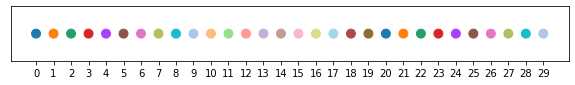

In [60]:
plt.figure(figsize=(10,1))
plt.scatter(list(main_modules.astype(str)), [1]*len(main_modules), c=list(map(mpl.colors.hex2color, map(lambda x: color_dict[x], main_modules))), s=80);
plt.yticks([]);

In [61]:
# with open(prefix + 'go.analysis/kmeans.modules/kmeans.n30.main.modules.genes.pkl', 'wb') as file:
#     pkl.dump(main_modules_genes, file)

In [62]:
with open(prefix + 'go.analysis/kmeans.modules/kmeans.n30.main.modules.genes.pkl', 'rb') as file:
    main_modules_genes = pkl.load(file)

### Adding Rows for Bulk and Pseudobulk

In [63]:
with open(prefix + 'pkls/aggr/pseuobulk.conds.inds.norm.pkl', 'rb') as file:
    pseudobulk_cond_inds_norm = pkl.load(file)
with open(prefix + '../../bulk.jan20/counts.norm.pkl', 'rb') as file:
    bulk_cond_inds_norm = pkl.load(file)

Are all the differentially expressed genes at least *found* in the bulk dataset (i.e. the gene all have the same name and were annotated in the bulk pipeline)? For the pseudobulk, the next cell should definitely pass, since all gene names in df_de should be a subset of those in pseudobulk_cond_inds_norm. But for the bulk it might not.

In [64]:
pseudobulk_cond_inds_norm = pseudobulk_cond_inds_norm[['COND', 'IND'] + df_de.columns.tolist()].copy()
bulk_cond_inds_norm = bulk_cond_inds_norm[['COND', 'IND'] + df_de.columns.tolist()].copy()

Ahh that's nice. Worked for bulk.

In [65]:
cond_inds_norm_means = dict()

In [66]:
for label, df in zip(['p', 'b'], [pseudobulk_cond_inds_norm, bulk_cond_inds_norm]):
    means = list()
    
    for cond in tqdm(['A', 'B', 'G', 'P', 'R']):
        means.append(df[df['COND'] == cond].mean()[1:].tolist())
    
    df = pd.DataFrame(means, 
                      index = [i + '_' + label for i in ['A', 'B', 'G', 'P', 'R']],
                      columns = df.columns[2:]
                     )
    obs = pd.DataFrame(index=df.index)
    var = pd.DataFrame(index=df.columns)
    adata = sc.AnnData(X=df.values, obs=obs, var=var)
    adata.var_names_make_unique()
    
    # They've already been normed soo....
#     sc.pp.normalize_total(adata, target_sum=1e6) 
    
#     cond_inds_norm_means[label] = pd.DataFrame(adata.X, index=obs.index, columns=var.index)
    cond_inds_norm_means[label] = adata

In [67]:
counts_for_heatmap = pseudobulk_conds_cts.iloc[:,2:]
obs = pd.DataFrame(index=pseudobulk_conds_cts['CT'] + '-' + pseudobulk_conds_cts['COND'])
var = pd.DataFrame(index=pseudobulk_conds_cts.iloc[:,2:].columns)

adata = sc.AnnData(X=counts_for_heatmap.values, obs=obs, var=var)
adata.var_names_make_unique()

sc.pp.normalize_total(adata, target_sum=1e6)

In [68]:
adata = adata.concatenate(cond_inds_norm_means['p'], cond_inds_norm_means['b'])

In [69]:
sc.pp.log1p(adata)
sc.pp.scale(adata)

Now back to a df because it's simpler.

In [70]:
df_de_bulk_compare = pd.DataFrame(adata[:,all_de_genes].X, index=adata.obs_names, columns=adata.var_names)

In [71]:
label_ordering = df_de_bulk_compare.iloc[:,np.argsort(kmeans.labels_)]
only_pb_compare = label_ordering.loc[[i for i in df_de_bulk_compare.index if '_p' in i or '_b' in i],:].sort_index()

In [72]:
ordered_conds = [i.split('_')[0] for i in only_pb_compare.index]
ordered_type = [i.split('_')[1].split('-')[0] for i in only_pb_compare.index]

In [73]:
print(ordered_cts)
print(ordered_type)

['B_Memory', 'B_Memory', 'B_Memory', 'B_Memory', 'B_Memory', 'B_Naive', 'B_Naive', 'B_Naive', 'B_Naive', 'B_Naive', 'CD4_T_Memory', 'CD4_T_Memory', 'CD4_T_Memory', 'CD4_T_Memory', 'CD4_T_Memory', 'CD4_T_Naive', 'CD4_T_Naive', 'CD4_T_Naive', 'CD4_T_Naive', 'CD4_T_Naive', 'CD8_T_Memory_MAIT_GD', 'CD8_T_Memory_MAIT_GD', 'CD8_T_Memory_MAIT_GD', 'CD8_T_Memory_MAIT_GD', 'CD8_T_Memory_MAIT_GD', 'CD8_T_Naive', 'CD8_T_Naive', 'CD8_T_Naive', 'CD8_T_Naive', 'CD8_T_Naive', 'HSC', 'HSC', 'HSC', 'HSC', 'HSC', 'NK', 'NK', 'NK', 'NK', 'NK', 'pDC', 'pDC', 'pDC', 'pDC', 'pDC', 'Mono_cDC_All', 'Mono_cDC_All', 'Mono_cDC_All', 'Mono_cDC_All', 'Mono_cDC_All', 'Mono_C', 'Mono_C', 'Mono_C', 'Mono_C', 'Mono_NC', 'Mono_NC', 'Mono_NC', 'Mono_NC', 'cDC', 'cDC', 'cDC', 'cDC']
['b', 'p', 'b', 'p', 'b', 'p', 'b', 'p', 'b', 'p']


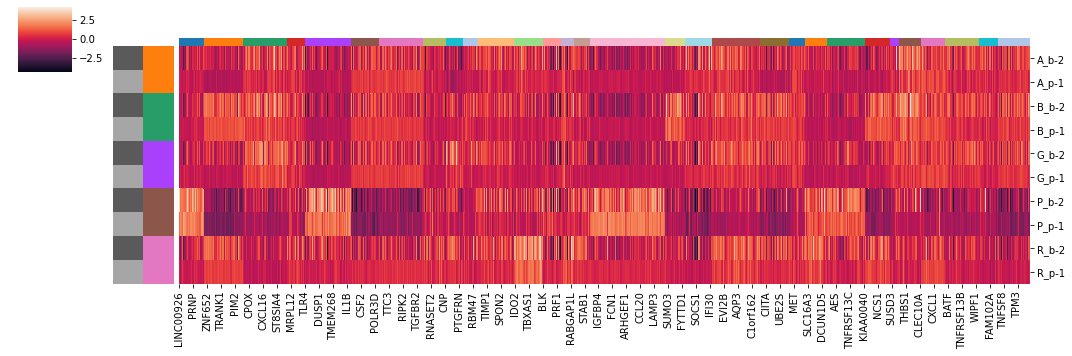

In [75]:
type_color = {'b': '#5a5a5a',
              'p': '#a6a6a6'
             }
cg = sns.clustermap(only_pb_compare, 
                    figsize=(15,5), 
                    row_cluster=False,
                    col_cluster=False,
                    col_colors=list(map(lambda x: color_dict[x], np.sort(kmeans.labels_))),
                    row_colors=[list(map(lambda x: type_color[x], ordered_type)), 
                                list(map(lambda x: cond_colors[x], ordered_conds))],
                    dendrogram_ratio=0.1,
                   );

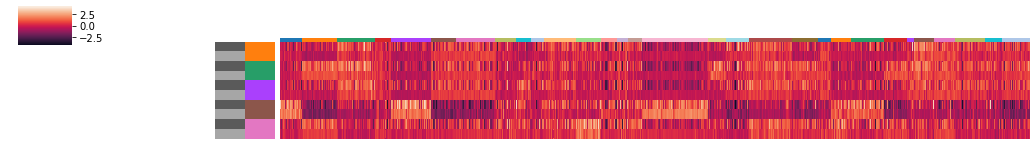

In [77]:
cg = sns.clustermap(only_pb_compare, 
                    figsize=(15,3), 
                    row_cluster=False,
                    col_cluster=False,
                    col_colors=list(map(lambda x: color_dict[x], np.sort(kmeans.labels_))),
                    row_colors=[list(map(lambda x: type_color[x], ordered_type)), 
                                list(map(lambda x: cond_colors[x], ordered_conds))]
                   );
# plt.tight_layout()
cg.ax_heatmap.set_yticklabels([])
cg.ax_heatmap.set_yticks([])
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.set_xticks([]);

## Gene Ontology

Run gene ontology analyses on the modules:

In [78]:
go_files_prefix = '/data/codec/' # just use the same one from the bulk analysis, downloads aint working, probably because of firewall
obo_fname = download_go_basic_obo(go_files_prefix + "go-basic.obo")
fin_gene2go = download_ncbi_associations(go_files_prefix + 'gene2go')

  EXISTS: /data/codec/go-basic.obo
  EXISTS: /data/codec/gene2go


In [79]:
obodag = GODag(go_files_prefix + "go-basic.obo")

/data/codec/go-basic.obo: fmt(1.2) rel(2020-02-21) 47,245 GO Terms


In [80]:
# Read NCBI's gene2go. Store annotations in a list of named tuples
objanno = Gene2GoReader(fin_gene2go, taxids=[9606])

# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated human genes".format(NS=nspc, N=len(id2gos)))

HMS:0:00:05.051069 323,107 annotations, 19,649 genes, 18,246 GOs, 1 taxids READ: /data/codec/gene2go 
MF 17,384 annotated human genes
CC 18,648 annotated human genes
BP 17,541 annotated human genes


In [81]:
gene_ids = list(GeneID2nt_hum.keys())
symbol2geneid = dict(zip([GeneID2nt_hum[i].Symbol for i in gene_ids], [i for i in gene_ids]))

Next cell produces a lot of output, recommend collapsing it in notebook.

In [82]:
results = list()
percent_genes_in_annot = list()
for module in tqdm(main_modules_genes):
    ids = list()

    for i in main_modules_genes[module]:
        try:
            ids.append(symbol2geneid[i])
        except:
            continue
    percent_genes_in_annot.append(len(ids)/len(main_modules_genes[module]))
    
    goeaobj = GOEnrichmentStudyNS(
            GeneID2nt_hum.keys(), # List of human protein-coding genes
            ns2assoc, # geneid/GO associations
            obodag, # Ontologies
            propagate_counts = False,
            alpha = 0.05, # default significance cut-off
            methods = ['fdr_bh']) # defult multipletest correction method
    
    goea_results_all = goeaobj.run_study(ids)
    for i in goea_results_all:
        results.append([str(module), i.name, i.NS, -np.log10(i.p_fdr_bh)])


Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 80% 16,711 of 20,913 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 85% 17,755 of 20,913 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 80% 16,699 of 20,913 population items found in association

Run BP Gene Ontology Analysis: current study set of 46 IDs ... 98%     45 of     46 study items found in association
100%     46 of     46 study items found in population(20913)
Calculating 12,176 uncorrected p-values using fisher_scipy_stats
  12,176 GO terms are associated with 16,711 of 20,913 population items
     519 GO terms are associated with     45 of     46 study items
  METHOD fdr_bh:
       8 GO terms found significant (< 0.05=alpha) (  8 enriched +   0 purified): statsmodels fdr_b

In [83]:
results_df = pd.DataFrame(results, columns=['Module', 'GO_term', 'GO_type', '-log10padj'])

In [84]:
results_df['Module'] = results_df['Module'].astype(np.int)

In [85]:
# with open(prefix + 'go.analysis/kmeans.modules/kmeans.n30.results_df.pkl', 'wb') as file:
#     pkl.dump(results_df, file)

In [86]:
with open(prefix + 'go.analysis/kmeans.modules/kmeans.n30.results_df.pkl', 'rb') as file:
    results_df = pkl.load(file)

Visualize the significance levels for the terms found in enriched in each module. BP = biological process, MF = molecular function, CC = cellular component.

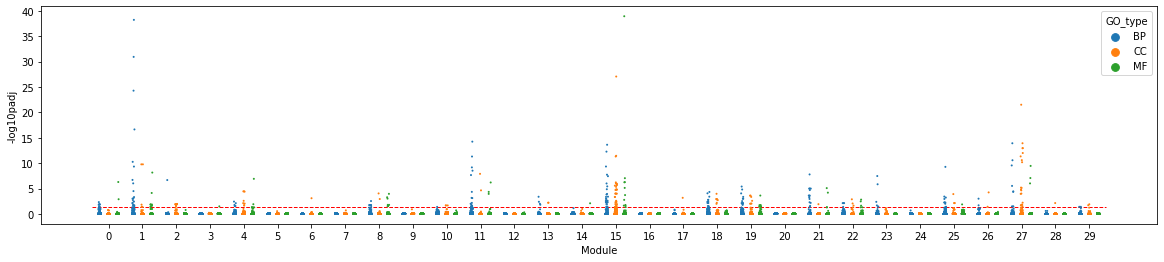

In [87]:
plt.figure(figsize=(20,4))
sns.stripplot(data=results_df,x='Module', hue='GO_type', y='-log10padj', dodge=True, size=2);
plt.plot([-0.5,len(main_modules) - 0.5],[-np.log10(0.05)]*2, linestyle='--', linewidth=1, color='r');

Is the lack of significance from some modules due to the fact that the gene names from that module did not exactly match gene names in the gene ontology dictionary?

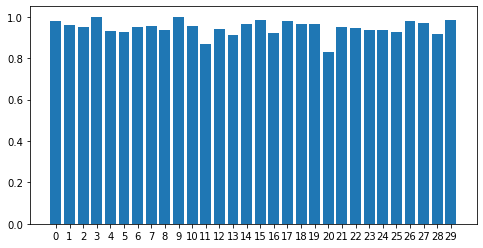

In [88]:
plt.figure(figsize=(8,4))
plt.bar([str(i) for i in main_modules], percent_genes_in_annot);

I think at least 60% of genes is okay.

### Print out and Explore GO Analysis Results

In [89]:
from IPython.display import display # need this to print out the results without truncation.

In [90]:
sig_dfs = dict()
for module in main_modules:
    df = results_df[(results_df['-log10padj'] > -np.log10(0.05)) &
                (results_df['Module'] == module)
               ][['GO_type', 'GO_term', '-log10padj']].sort_values(['GO_type', '-log10padj'], ascending=False)
    sig_dfs[module] = df.copy()

In [91]:
for module in sig_dfs:
    print((module, len(sig_dfs[module])))

(0, 10)
(1, 37)
(2, 10)
(3, 1)
(4, 19)
(5, 0)
(6, 1)
(7, 0)
(8, 18)
(9, 0)
(10, 4)
(11, 20)
(12, 0)
(13, 6)
(14, 1)
(15, 77)
(16, 0)
(17, 1)
(18, 19)
(19, 27)
(20, 0)
(21, 19)
(22, 10)
(23, 6)
(24, 0)
(25, 16)
(26, 4)
(27, 31)
(28, 1)
(29, 4)


In [92]:
module = 25
with pd.option_context('display.max_rows', 150, 'display.max_columns', 10, 'display.max_colwidth', -1):
    display(results_df[(results_df['Module'] == module) & (results_df['GO_type'] == 'MF')].sort_values('-log10padj', ascending=False).head(5))
    display(results_df[(results_df['Module'] == module) & (results_df['GO_type'] == 'CC')].sort_values('-log10padj', ascending=False).head(5))
    display(results_df[(results_df['Module'] == module) & (results_df['GO_type'] == 'BP')].sort_values('-log10padj', ascending=False).head(5))

,Module,GO_term,GO_type,-log10padj
465532,25,complement component C5a receptor activity,MF,1.873942
465533,25,syndecan binding,MF,0.855246
465534,25,scavenger receptor activity,MF,0.822709
465535,25,RAGE receptor binding,MF,0.758353
465536,25,low-density lipoprotein particle receptor activity,MF,0.758353


,Module,GO_term,GO_type,-log10padj
463801,25,integral component of plasma membrane,CC,3.906649
463803,25,plasma membrane,CC,2.135238
463804,25,cell,CC,2.135238
463802,25,extracellular region,CC,2.135238
463805,25,endocytic vesicle membrane,CC,1.108065


,Module,GO_term,GO_type,-log10padj
451625,25,inflammatory response,BP,9.269444
451626,25,positive regulation of ERK1 and ERK2 cascade,BP,3.419783
451627,25,neutrophil degranulation,BP,3.221387
451628,25,neutrophil chemotaxis,BP,2.946683
451629,25,chemotaxis,BP,2.252420


In [100]:
sig_modules = np.array([0, 1, 2, 4, 8, 10, 11, 13, 15, 18, 19, 21, 22, 23, 25, 26, 27, 29])
# sig_modules = main_modules

In [101]:
len(sig_modules)

18

In [102]:
for module in sig_modules:
    with pd.option_context('display.max_rows', 150, 'display.max_columns', 10, 'display.max_colwidth', -1):
        print(module)
        
#         display(sig_dfs[module][:10])
        
        display(sig_dfs[module][sig_dfs[module]['GO_type'] == 'MF'][:5])
        display(sig_dfs[module][sig_dfs[module]['GO_type'] == 'CC'][:5])
        display(sig_dfs[module][sig_dfs[module]['GO_type'] == 'BP'][:5])


0


,GO_type,GO_term,-log10padj
13907,MF,cytokine activity,6.285323
13908,MF,tumor necrosis factor receptor binding,2.891819


,GO_type,GO_term,-log10padj


,GO_type,GO_term,-log10padj
0,BP,positive regulation of tyrosine phosphorylation of STAT protein,2.326928
1,BP,immune response,1.875752
2,BP,regulation of regulatory T cell differentiation,1.875752
3,BP,negative regulation of interleukin-2 production,1.875752
4,BP,positive regulation of T cell chemotaxis,1.875752


1


,GO_type,GO_term,-log10padj
31972,MF,double-stranded RNA binding,8.147779
31973,MF,2'-5'-oligoadenylate synthetase activity,4.126876
31974,MF,RNA binding,1.869997
31975,MF,single-stranded RNA binding,1.853017
31976,MF,ubiquitin-protein transferase activity,1.853017


,GO_type,GO_term,-log10padj
30241,CC,cytoplasm,9.767301
30242,CC,cytosol,9.767301
30243,CC,nucleoplasm,1.827584
30244,CC,postsynaptic endocytic zone membrane,1.395091
30245,CC,nucleus,1.395091


,GO_type,GO_term,-log10padj
18065,BP,defense response to virus,38.228982
18066,BP,type I interferon signaling pathway,30.937257
18067,BP,response to virus,24.282763
18068,BP,negative regulation of viral genome replication,16.642697
18069,BP,interferon-gamma-mediated signaling pathway,10.260797


2


,GO_type,GO_term,-log10padj


,GO_type,GO_term,-log10padj
48306,CC,collagen-containing extracellular matrix,1.962372
48307,CC,plasma membrane,1.962372
48308,CC,lysosomal lumen,1.911808
48309,CC,lysosome,1.911808
48310,CC,integral component of membrane,1.911808


,GO_type,GO_term,-log10padj
36130,BP,neutrophil degranulation,6.671719


4


,GO_type,GO_term,-log10padj
86167,MF,protein binding,6.913043
86168,MF,unfolded protein binding,1.909580
86169,MF,chaperone binding,1.328285
86170,MF,RNA binding,1.328285
86171,MF,"ATPase activity, coupled",1.328285


,GO_type,GO_term,-log10padj
84436,CC,cytosol,4.445231
84437,CC,nucleus,4.445231
84438,CC,cytoplasm,4.393656
84439,CC,chaperone complex,2.577851
84440,CC,extracellular exosome,2.119173


,GO_type,GO_term,-log10padj
72260,BP,cellular response to glucose starvation,2.425931
72261,BP,response to unfolded protein,2.116900
72262,BP,chaperone cofactor-dependent protein refolding,1.771620
72263,BP,cytokine-mediated signaling pathway,1.566680
72264,BP,PERK-mediated unfolded protein response,1.566680


8


,GO_type,GO_term,-log10padj
158427,MF,CXCR3 chemokine receptor binding,3.956467
158428,MF,GTPase activity,3.276923
158429,MF,GTP binding,3.015622
158430,MF,protein homodimerization activity,1.782542
158431,MF,kinase inhibitor activity,1.782542


,GO_type,GO_term,-log10padj
156696,CC,symbiont-containing vacuole membrane,4.036445
156697,CC,cytoplasmic vesicle,2.934378


,GO_type,GO_term,-log10padj
144520,BP,cellular response to interferon-gamma,2.536564
144521,BP,defense response,1.738592
144522,BP,leukocyte chemotaxis,1.738592
144523,BP,defense response to protozoan,1.738592
144524,BP,positive regulation of release of sequestered calcium ion into cytosol,1.736934


10


,GO_type,GO_term,-log10padj


,GO_type,GO_term,-log10padj
192826,CC,extracellular exosome,1.673186
192827,CC,cytosol,1.673186
192828,CC,focal adhesion,1.673186


,GO_type,GO_term,-log10padj
180650,BP,positive regulation of angiogenesis,1.378757


11


,GO_type,GO_term,-log10padj
212622,MF,cytokine activity,6.196083
212623,MF,interleukin-1 receptor binding,4.338881
212624,MF,chemokine activity,3.946807


,GO_type,GO_term,-log10padj
210891,CC,extracellular space,7.894418
210892,CC,extracellular region,4.640883


,GO_type,GO_term,-log10padj
198715,BP,cellular response to lipopolysaccharide,14.239386
198716,BP,cytokine-mediated signaling pathway,11.307404
198717,BP,neutrophil chemotaxis,9.165485
198718,BP,inflammatory response,8.518767
198719,BP,leukocyte chemotaxis,7.655741


13


,GO_type,GO_term,-log10padj


,GO_type,GO_term,-log10padj
247021,CC,B cell receptor complex,2.204772
247022,CC,external side of plasma membrane,2.204772


,GO_type,GO_term,-log10padj
234845,BP,B cell receptor signaling pathway,3.380946
234846,BP,adaptive immune response,2.390581
234847,BP,B cell activation,1.991406
234848,BP,B cell proliferation,1.807442


15


,GO_type,GO_term,-log10padj
284882,MF,RNA binding,38.941481
284883,MF,protein binding,7.040822
284884,MF,unfolded protein binding,6.259719
284885,MF,snoRNA binding,6.233968
284886,MF,box H/ACA snoRNA binding,5.124416


,GO_type,GO_term,-log10padj
283151,CC,nucleolus,27.065177
283152,CC,nucleoplasm,11.449843
283153,CC,"preribosome, large subunit precursor",11.313325
283154,CC,small nucleolar ribonucleoprotein complex,6.206921
283155,CC,chaperonin-containing T-complex,6.005108


,GO_type,GO_term,-log10padj
270975,BP,rRNA processing,13.625592
270976,BP,positive regulation of telomerase RNA localization to Cajal body,12.270415
270977,BP,ribosomal large subunit biogenesis,9.338067
270978,BP,positive regulation of protein localization to Cajal body,7.730103
270979,BP,positive regulation of establishment of protein localization to telomere,7.431429


18


,GO_type,GO_term,-log10padj


,GO_type,GO_term,-log10padj
337346,CC,extracellular space,3.966572
337347,CC,plasma membrane,2.938194
337348,CC,cell,2.938194
337349,CC,extracellular region,2.848731
337350,CC,ficolin-1-rich granule membrane,2.720796


,GO_type,GO_term,-log10padj
325170,BP,inflammatory response,4.329707
325171,BP,cell surface receptor signaling pathway,4.060249
325172,BP,innate immune response,3.395610
325173,BP,neutrophil degranulation,2.770653
325174,BP,positive regulation of inflammatory response,2.770653


19


,GO_type,GO_term,-log10padj
357142,MF,TAP1 binding,3.618463
357143,MF,peptide antigen binding,1.723985
357144,MF,ATPase-coupled peptide antigen transmembrane transporter activity,1.723985
357145,MF,TAP2 binding,1.723985
357146,MF,protein homodimerization activity,1.470378


,GO_type,GO_term,-log10padj
355411,CC,MHC class I protein complex,3.602638
355412,CC,MHC class I peptide loading complex,3.602638
355413,CC,phagocytic vesicle membrane,3.348103
355414,CC,MHC class Ib protein complex,2.581001
355415,CC,early endosome membrane,2.033563


,GO_type,GO_term,-log10padj
343235,BP,interferon-gamma-mediated signaling pathway,5.391576
343236,BP,antigen processing and presentation of peptide antigen via MHC class I,4.811103
343237,BP,"antigen processing and presentation of exogenous peptide antigen via MHC class I, TAP-dependent",4.045015
343238,BP,"antigen processing and presentation of exogenous peptide antigen via MHC class I, TAP-independent",3.356726
343239,BP,type I interferon signaling pathway,2.990277


21


,GO_type,GO_term,-log10padj
393272,MF,CCR chemokine receptor binding,5.083052
393273,MF,chemokine activity,4.190189
393274,MF,CCR1 chemokine receptor binding,1.329738


,GO_type,GO_term,-log10padj
391541,CC,extracellular space,1.917347


,GO_type,GO_term,-log10padj
379365,BP,monocyte chemotaxis,7.780341
379366,BP,cytokine-mediated signaling pathway,5.011891
379367,BP,positive regulation of ERK1 and ERK2 cascade,4.990903
379368,BP,lymphocyte chemotaxis,4.990903
379369,BP,cellular response to interleukin-1,4.697603


22


,GO_type,GO_term,-log10padj
411337,MF,ubiquitin protein ligase binding,2.819264
411338,MF,protein binding,2.467002
411339,MF,MHC class II protein complex binding,1.625670


,GO_type,GO_term,-log10padj
409606,CC,melanosome,2.879104
409607,CC,I-kappaB/NF-kappaB complex,2.057926
409608,CC,nucleus,1.634139


,GO_type,GO_term,-log10padj
397430,BP,apoptotic process,2.126537
397431,BP,NIK/NF-kappaB signaling,2.126537
397432,BP,tumor necrosis factor-mediated signaling pathway,2.126537
397433,BP,interleukin-1-mediated signaling pathway,1.387968


23


,GO_type,GO_term,-log10padj


,GO_type,GO_term,-log10padj


,GO_type,GO_term,-log10padj
415495,BP,negative regulation of viral genome replication,7.463661
415496,BP,defense response to virus,5.841110
415497,BP,response to interferon-beta,2.377925
415498,BP,negative regulation of viral entry into host cell,1.675465
415499,BP,response to interferon-gamma,1.439039


25


,GO_type,GO_term,-log10padj
465532,MF,complement component C5a receptor activity,1.873942


,GO_type,GO_term,-log10padj
463801,CC,integral component of plasma membrane,3.906649
463802,CC,extracellular region,2.135238
463803,CC,plasma membrane,2.135238
463804,CC,cell,2.135238


,GO_type,GO_term,-log10padj
451625,BP,inflammatory response,9.269444
451626,BP,positive regulation of ERK1 and ERK2 cascade,3.419783
451627,BP,neutrophil degranulation,3.221387
451628,BP,neutrophil chemotaxis,2.946683
451629,BP,chemotaxis,2.252420


26


,GO_type,GO_term,-log10padj


,GO_type,GO_term,-log10padj
481866,CC,T cell receptor complex,4.237970
481867,CC,alpha-beta T cell receptor complex,1.408667


,GO_type,GO_term,-log10padj
469690,BP,adaptive immune response,3.002091
469691,BP,positive regulation of T cell receptor signaling pathway,1.692677


27


,GO_type,GO_term,-log10padj
501662,MF,peptide antigen binding,9.457468
501663,MF,MHC class II receptor activity,7.070890
501664,MF,MHC class II protein complex binding,6.013817


,GO_type,GO_term,-log10padj
499931,CC,MHC class II protein complex,21.513459
499932,CC,integral component of lumenal side of endoplasmic reticulum membrane,13.921216
499933,CC,lysosomal membrane,12.953933
499934,CC,clathrin-coated endocytic vesicle membrane,12.953933
499935,CC,transport vesicle membrane,11.996427


,GO_type,GO_term,-log10padj
487755,BP,antigen processing and presentation of exogenous peptide antigen via MHC class II,13.917771
487756,BP,interferon-gamma-mediated signaling pathway,10.573005
487757,BP,adaptive immune response,9.551001
487758,BP,T cell receptor signaling pathway,5.518024
487759,BP,immune response,4.441039


29


,GO_type,GO_term,-log10padj


,GO_type,GO_term,-log10padj
536061,CC,protease inhibitor complex,1.898452
536062,CC,ficolin-1-rich granule lumen,1.718139


,GO_type,GO_term,-log10padj
523885,BP,neutrophil degranulation,1.402276
523886,BP,inflammatory response,1.402276


In [ ]:
for module in sig_modules:
    print(module)
    print(sig_dfs[module][sig_dfs[module]['GO_term'].str.contains('cAMP')])

In [ ]:
with pd.option_context('display.max_rows', 150, 'display.max_columns', 10, 'display.max_colwidth', -1):
    display(sig_dfs[module][sig_dfs[module]['GO_type'] == 'BP'])

In [104]:
dfs = list()
for sig_module in sig_modules:
    dfs.append(results_df[(results_df['-log10padj'] > -np.log10(0.05)) &
                          (results_df['Module'] == sig_module)
                         ][['Module', 'GO_type', 'GO_term', '-log10padj']].sort_values(['GO_type', '-log10padj'], ascending=False))

In [105]:
pd.concat(dfs).to_csv(prefix + 'go.analysis/kmeans.modules/kmeans.n30.sig.modules.GO.csv')

### Label the Significant Modules

In [106]:
sig_module_labels = {
    0: 'STAT activation via TNF signaling',
    1: 'viral response & interferon activity',
    2: 'granule exocytosis',
    4: 'unfolded protein response',
    8: 'CXCR3 binding and IFN-gamma response',
    10: 'positive regulation of angiogenesis',
    11: 'LPS response & cytokine activity',
    13: 'B cell activation',
    11: 'LPS response & cytokine activity',
    15: 'Cajal body formation and telomerase activity',
    18: 'inflammation and metal ion response',
    19: 'IFN-gamma response and MHC I activity',
    21: 'CCR1 binding and chemoktaxis',
    22: 'TNF alpha response and NFKb signaling',
    23: 'response to viral entry & interferon activity',
    25: 'complement activity and chemotaxis',
    26: 'TCR signaling',
    27: 'MHC II activity',
    28: 'intracellular degranulation pathway'
}

In [107]:
len(sig_modules)

I realized that plotting mean expression of the genes in each module may reduce the signal for genes that are part of a module (and contribute to the module's signifance) but that are downregulated. Therefore, going to plot the mean log fold change (from control) of genes within the module, and just won't plot control (since it will be 1).

In [ ]:
# specific_counts = specific_counts.abs()
# specific_counts = specific_counts.reset_index()

# specific_counts['TIME'] = specific_counts['TIME'].astype(int)

# specific_counts.mean(axis=0,level=['TIME', 'STIM']).head()

# specific_counts.sort_values(['STIM','TIME','IND'])

NameError: name 'counts' is not defined

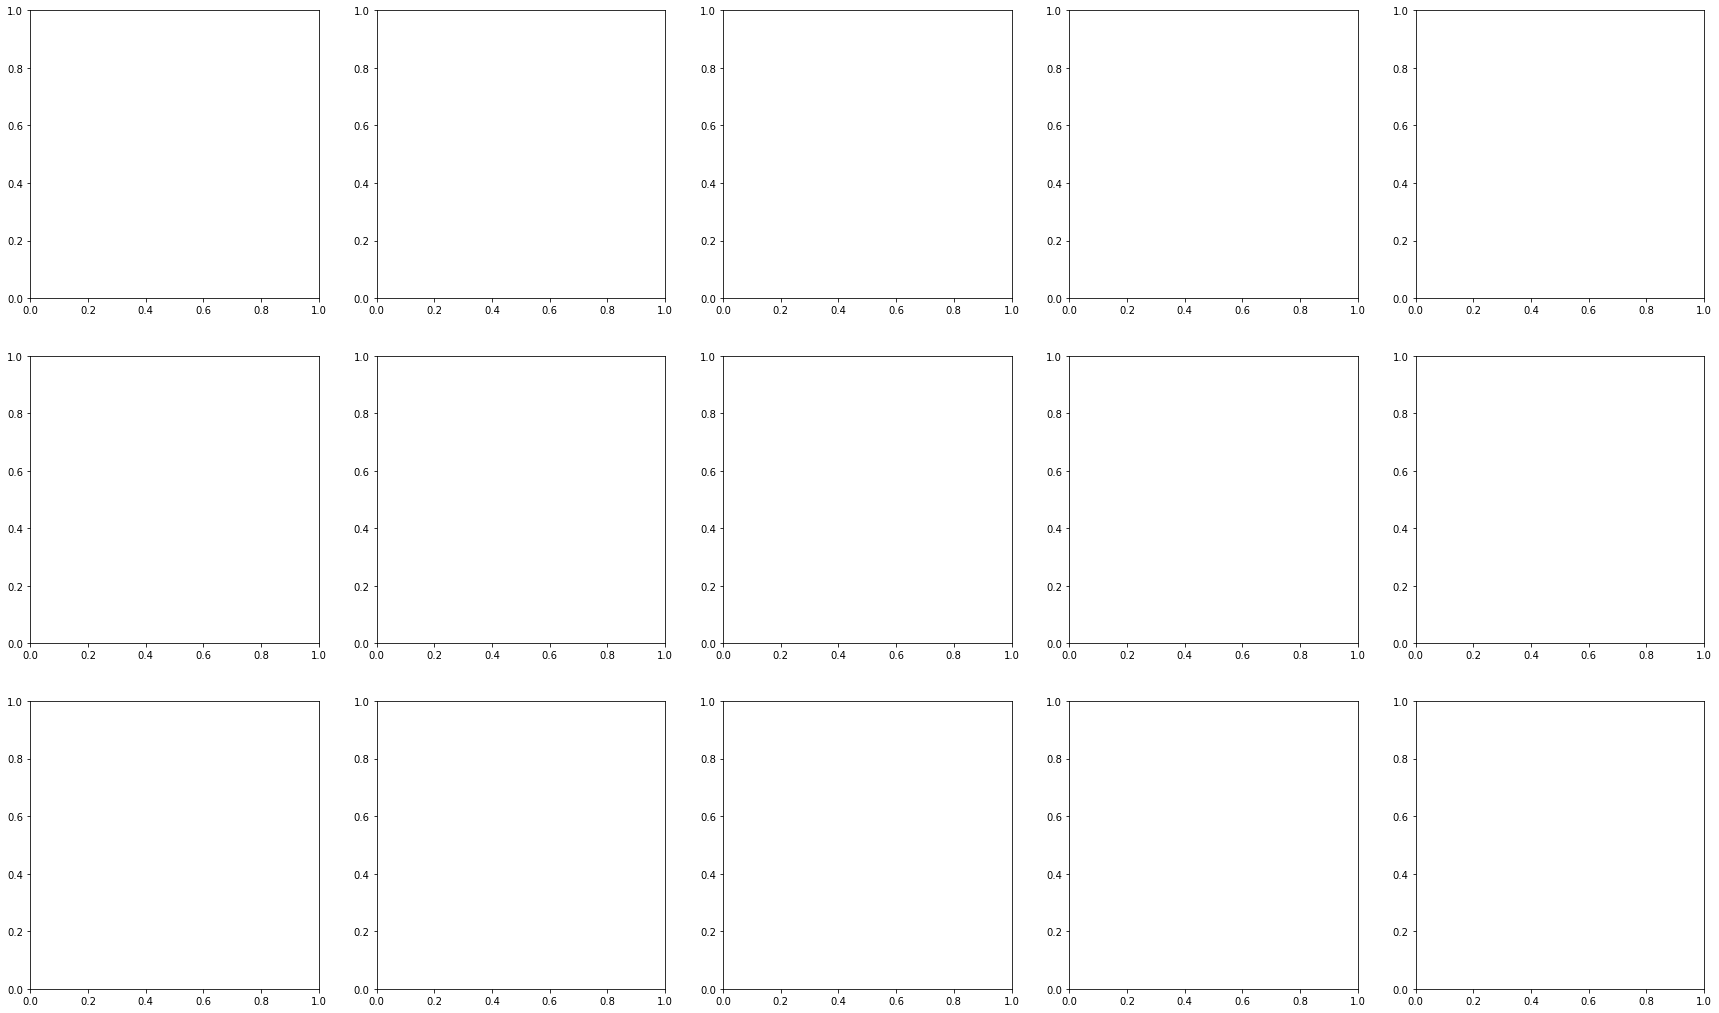

In [110]:
fig, ax = plt.subplots(3, 5, figsize=(30,18))
for sig_module, ax in zip(sig_modules, np.ravel(ax)):
#     gene_union = np.unique(np.concatenate([de_genes[stim][i] for i in hours]))
#     specific_counts = counts['norm'][gene_union]

    specific_counts = counts['norm_lfc'][main_modules_genes[sig_module]]#.abs()
    means = specific_counts.mean(1)

    means.rename('Mean Log Fold Change (from Control)', inplace=True);

    tidy_means = means.reset_index()
    tidy_means['TIME'] = tidy_means['TIME'].astype(int)
    # tidy_means = tidy_means[(tidy_means['STIM'] == stim) | (tidy_means['STIM'] == 'Control')]

    sns.lineplot(x="TIME",y='Mean Log Fold Change (from Control)',data=tidy_means, hue='STIM', err_style="band", ci="sd", ax=ax, palette=cond_colors);
    ax.grid(False)
#     ax.set_yscale('log')
    ax.set_ylabel(None)
    ymax = ax.get_ylim()[1]
#     ax.set_ylim((0,ymax))
    ax.set_title(str(sig_module_labels[sig_module]) + ' (' + str(sig_module) + ')')
    ax.get_legend().remove()
    ax.plot([3, 12], [0, 0], linestyle='--', color='r', linewidth=1)
plt.tight_layout()

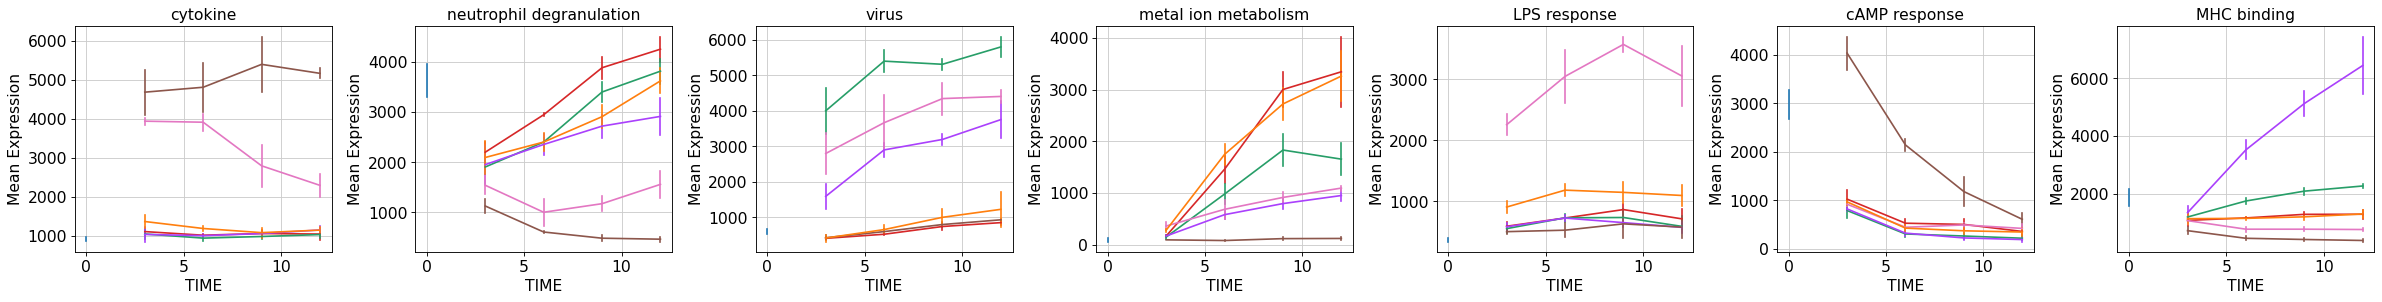

In [339]:
fig, ax = plt.subplots(1, 7, figsize=(30,4))
for sig_module, ax in zip(sig_modules, np.ravel(ax)):
#     gene_union = np.unique(np.concatenate([de_genes[stim][i] for i in hours]))
#     specific_counts = counts['norm'][gene_union]

    specific_counts = counts['norm'][main_modules_genes[sig_module]]

    means = specific_counts.mean(1)

    means.rename('Mean Expression', inplace=True);

    tidy_means = means.reset_index()
    tidy_means['TIME'] = tidy_means['TIME'].astype(int)
    # tidy_means = tidy_means[(tidy_means['STIM'] == stim) | (tidy_means['STIM'] == 'Control')]

    sns.lineplot(x="TIME",y='Mean Expression',data=tidy_means, hue='STIM', err_style="bars", ci="sd", ax=ax, palette=color_dict);
    ax.set_title(str(sig_module_labels[sig_module]))
    ax.get_legend().remove()
plt.tight_layout()

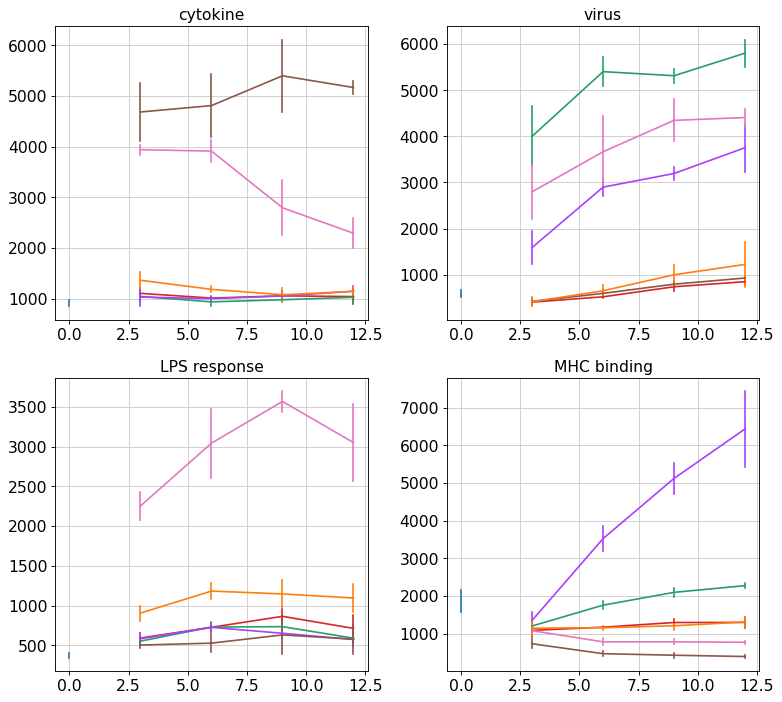

In [347]:
fig, ax = plt.subplots(2, 2, figsize=(10,9))
for sig_module, ax in zip([1, 6, 10, 41], np.ravel(ax)):
#     gene_union = np.unique(np.concatenate([de_genes[stim][i] for i in hours]))
#     specific_counts = counts['norm'][gene_union]

    specific_counts = counts['norm'][main_modules_genes[sig_module]]

    means = specific_counts.mean(1)

    means.rename('Mean Expression', inplace=True);

    tidy_means = means.reset_index()
    tidy_means['TIME'] = tidy_means['TIME'].astype(int)
    # tidy_means = tidy_means[(tidy_means['STIM'] == stim) | (tidy_means['STIM'] == 'Control')]

    sns.lineplot(x="TIME",y='Mean Expression',data=tidy_means, hue='STIM', err_style="bars", ci="sd", ax=ax, palette=color_dict);
    ax.set_title(str(sig_module_labels[sig_module]))
    ax.get_legend().remove()
    ax.set_ylabel(None)
    ax.set_xlabel(None)
plt.tight_layout()

# Extra

Using the 90th percentile positive log2fc and the p_adj < 0.01, I will now extract out differentially expressed genes.

In [9]:
de_genes = dict() # make a dictionary

for cond in conds_1: # this has all the conditions
    de_genes[cond] = dict() # each value will be each cond, itself be a dictionary with values of cts

In [10]:
# for each cond, each non-zero ct...
combos = list(it.product(conds_1, cts_1)) 
for combo in combos: 
    cond = combo[0]
    ct = combo[1]
    df = de[cond][ct] # get the DE results
    
    df = df[df['log2FoldChange'] > 0] # only keep those that are positive
    
    # It was in this moment that I realized, the myeloid PMA/I cells also probably capture the cDCs, and
    # therefore they also shouldn't be included in the cDC cell types either, and perhaps Mono_Other_PMA
    # is a misnomer and it should probably be Myeloid_Other_PMA
    # It was for this reason that the log2FoldChange ended up being all negative probably because
    # there was only a handful of cells in the PMAI condition in cDCs
    # therefore, running a check right now to make sure the df isn't empty after subsetting for positive
    # values, but I should go back to the explore.cts notebook when I made the pseuodobulks and reaccount for this
    
    if len(df) == 0:
        continue
    
    fc_thresh = np.percentile(df['log2FoldChange'],90) # calculate threshold of now only positive values
    
    # extract out genes, add them to the dictionary as a list
    de_genes[cond][ct] = df[(df['log2FoldChange'] > fc_thresh) & 
                                    (df['padj'] < 0.01)]
    de_genes[cond][ct]['-log10padj'] = -np.log10(de_genes[cond][ct]['padj'])

/home/ssm-user/anaconda3/envs/codec/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ssm-user/anaconda3/envs/codec/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
# for each cond, each non-zero ct...
combos = list(it.product(conds_2, cts_2)) 
for combo in tqdm(combos): 
    cond = combo[0]
    ct = combo[1]
    df = de[cond][ct] # get the DE results
    
    df = df[df['log2FoldChange'] > 0] # only keep those that are positive
    
    # It was in this moment that I realized, the myeloid PMA/I cells also probably capture the cDCs, and
    # therefore they also shouldn't be included in the cDC cell types either, and perhaps Mono_Other_PMA
    # is a misnomer and it should probably be Myeloid_Other_PMA
    # It was for this reason that the log2FoldChange ended up being all negative probably because
    # there was only a handful of cells in the PMAI condition in cDCs
    # therefore, running a check right now to make sure the df isn't empty after subsetting for positive
    # values, but I should go back to the explore.cts notebook when I made the pseuodobulks and reaccount for this
    
    if len(df) == 0:
        continue
    
    fc_thresh = np.percentile(df['log2FoldChange'],90) # calculate threshold of now only positive values
    
    # extract out genes, add them to the dictionary as a list
    de_genes[cond][ct] = df[(df['log2FoldChange'] > fc_thresh) & 
                                    (df['padj'] < 0.01)]
    de_genes[cond][ct] = df[(df['log2FoldChange'] > fc_thresh) & 
                                    (df['padj'] < 0.01)]
    de_genes[cond][ct]['-log10padj'] = -np.log10(de_genes[cond][ct]['padj'])

/home/ssm-user/anaconda3/envs/codec/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
num_genes = pd.DataFrame(index=conds_1, columns=cts_1)
for cond in conds_1:
    for ct in cts_1:
        num_genes.loc[cond, ct] = len(de_genes[cond][ct])

In [13]:
num_genes

,B_Memory,B_Naive,CD4_T_Memory,CD4_T_Naive,CD8_T_Memory_MAIT_GD,CD8_T_Naive,HSC,NK,pDC,Mono_cDC_All
A,0,0,3,58,8,10,45,8,135,392
B,502,609,396,706,460,251,79,480,651,493
G,106,157,21,287,0,61,52,0,0,653
P,880,666,442,808,591,790,232,474,408,1001
R,888,926,547,839,613,330,169,585,842,656


In [14]:
num_genes = pd.DataFrame(index=conds_2, columns=cts_2)
for cond in conds_2:
    for ct in cts_2:
        num_genes.loc[cond, ct] = len(de_genes[cond][ct])

In [15]:
num_genes

,Mono_C,Mono_NC,cDC
A,328,48,118
B,477,446,676
G,661,332,484
R,588,425,406


In [16]:
ct_specific_de_genes = dict()

In [17]:
for cond in tqdm(conds_1):
    cond_cts = list(de_genes[cond].keys())
    ct_specific_de_genes[cond] = dict()
    for ct in cond_cts:
        other_ct_de_genes_map = map(lambda ct: de_genes[cond][ct].index.values, [i for i in cond_cts if i != ct])
        other_ct_de_genes = np.unique([i for j in other_ct_de_genes_map for i in j])
        ct_specific_de_genes[cond][ct] = de_genes[cond][ct].loc[np.setdiff1d(de_genes[cond][ct].index.values, other_ct_de_genes)]

In [18]:
num_genes = pd.DataFrame(index=conds_1, columns=cts_1)
for cond in conds_1:
    for ct in cts_1:
        num_genes.loc[cond, ct] = len(ct_specific_de_genes[cond][ct])

In [19]:
num_genes

,B_Memory,B_Naive,CD4_T_Memory,CD4_T_Naive,CD8_T_Memory_MAIT_GD,CD8_T_Naive,HSC,NK,pDC,Mono_cDC_All
A,0,0,0,39,0,0,27,0,104,39
B,31,76,4,143,22,0,2,40,363,8
G,5,16,0,80,0,0,4,0,0,20
P,131,38,11,50,21,51,43,20,150,816
R,104,198,22,145,41,0,6,47,341,29


In [20]:
num_genes = pd.DataFrame(index=conds_2, columns=cts_2)
for cond in conds_2:
    for ct in cts_2:
        num_genes.loc[cond, ct] = len(ct_specific_de_genes[cond][ct])

In [21]:
num_genes

,Mono_C,Mono_NC,cDC
A,5,1,26
B,4,37,127
G,36,38,131
R,3,48,39


In [22]:
de_genes['B']['CD8_T_Memory_MAIT_GD'].sort_values(by='-log10padj', ascending=False)[:20]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,-log10padj
IFIT1,90.366365,4.252715,0.180466,23.565230,8.763288e-123,9.163770e-119,118.037926
IFI6,267.951834,4.325477,0.194701,22.215973,2.407132e-109,1.258569e-105,104.900123
IFIT3,98.862932,4.166066,0.189302,22.007509,2.440392e-107,6.379794e-104,103.195193
RSAD2,54.178603,4.139642,0.188009,22.018350,1.921331e-107,6.379794e-104,103.195193
IFI44L,48.280330,3.950867,0.180428,21.897197,2.762600e-106,5.777702e-103,102.238245
IFIT2,74.719979,3.992685,0.186350,21.425717,7.694150e-102,1.340962e-98,97.872584
MX1,148.391317,3.934166,0.190032,20.702701,3.274925e-95,4.892270e-92,91.310490
OAS3,23.196968,3.748438,0.183734,20.401463,1.622855e-92,2.121274e-89,88.673403
CMPK2,23.917225,3.570004,0.175711,20.317417,9.019903e-92,1.048012e-88,87.979634
HERC5,61.215823,3.596894,0.178918,20.103556,6.869064e-90,7.182981e-87,86.143695
